In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import h5py

%matplotlib inline

### 读取数据

In [2]:
total_df = pd.read_csv('./data/train.csv')
total_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
final_df = pd.read_csv('./data/test.csv')
final_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
total_X = total_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
total_Y = total_df.iloc[:, 0].values.reshape(-1, 1)
final_X = final_df.iloc[:, :].values.reshape(-1, 28, 28, 1)

print('total_X:', total_X.shape)
print('total_Y:', total_Y.shape)
print('final_X:', final_X.shape)

total_X: (42000, 28, 28, 1)
total_Y: (42000, 1)
final_X: (28000, 28, 28, 1)


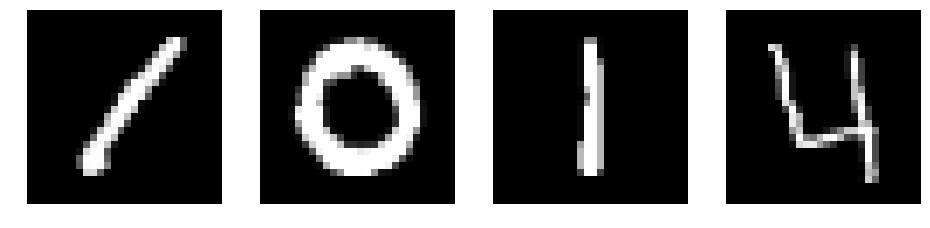

In [5]:
plt.figure(figsize=(16, 16))
plt.rcParams['image.cmap'] = 'gray'
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(total_X[i, :, :, 0])
    plt.axis('off')

### 数据随机化

In [6]:
random_indexes = np.random.permutation(total_X.shape[0])
total_shuffle_X = total_X[random_indexes]
total_shuffle_Y = total_Y[random_indexes]

### 用imagenet预训练的resnet提取所有图片特征，保存到文件

In [7]:
def build_placeholder():
    inputs = tf.placeholder(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    
    return inputs

In [8]:
def image_process_map(image):
    rgb_image = tf.concat([image, image, image], axis=-1)
    resize_image = tf.image.resize_images(rgb_image, size=(224, 224))
    pre_image = keras.applications.resnet50.preprocess_input(resize_image, mode='tf')
    
    return pre_image;

In [9]:
def data_gen(images, batch_size):
    images_set = tf.data.Dataset.from_tensor_slices(images)
    images_set = images_set.batch(batch_size)
    images_set = images_set.repeat(1)
    images_set = images_set.map(image_process_map, 8)
    images_gen = images_set.make_one_shot_iterator()
    next_images = images_gen.get_next()
    
    return next_images

In [10]:
def features_extraction_model(images, batch_size=8):  
    tf.reset_default_graph()
    
    inputs_pl = build_placeholder()
    resnet = keras.applications.resnet50.ResNet50(include_top=False, input_tensor=inputs_pl, pooling='avg')
    
    with tf.device('/cpu:0'):
        images_gen = data_gen(images, batch_size)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    features_array = []
    step = 0
    while True:
        try:
            input_images = sess.run(images_gen)
            batch_features = sess.run(resnet.output, feed_dict={inputs_pl: input_images})
            features_array.append(batch_features)
            print('step:', step, '--', end=' ')
            step += 1
        except tf.errors.OutOfRangeError:
            print('feature extraction complete')
            break
    
    result_features = np.concatenate(features_array, axis=0)
    sess.close()
    
    return result_features

In [11]:
features = features_extraction_model(total_shuffle_X[:2])
print('features_shape:', features.shape)

step: 0 -- feature extraction complete
features_shape: (2, 2048)
